In [ ]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model

def parseDataFromURL(fname):
  for l in urlopen(fname):
    yield eval(l)

def parseData(fname):
  for l in open(fname):
    yield eval(l)

print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse258/data/amazon/book_descriptions_50000.json
data = list(parseData("data/amazon/book_descriptions_50000.json"))
print("done")

### Naive bayes to determine p(childrens book | mentions wizards and mentions witches) ###

# p(childrens book)
prior = ["Children's Books" in b['categories'] for b in data]
prior = sum(prior) * 1.0 / len(prior)

# p(isn't children's book)
prior_neg = 1 - prior

# p(mentions wizards | is childrens)
p1 = ['wizard' in b['description'] for b in data if "Children's Books" in b['categories']]
p1 = sum(p1) * 1.0 / len(p1)

# p(mentions wizards | isn't childrens)
p1_neg = ['wizard' in b['description'] for b in data if not ("Children's Books" in b['categories'])]
p1_neg = sum(p1_neg) * 1.0 / len(p1_neg)

# p(mentions witches | is childrens)
p2 = ['witch' in b['description'] for b in data if "Children's Books" in b['categories']]
p2 = sum(p2) * 1.0 / len(p2)

# p(mentions witches | isn't childrens)
p2_neg = ['witch' in b['description'] for b in data if not ("Children's Books" in b['categories'])]
p2_neg = sum(p2_neg) * 1.0 / len(p2_neg)

# Prediction

score = prior * p1 * p2
score_neg = prior_neg * p1_neg * p2_neg

# Actual ('non-naive') probability

p = ["Children's Books" in b['categories'] for b in data if 'witch' in b['description'] and 'wizard' in b['description']]
p = sum(p) * 1.0 / len(p)

### Logistic Regression -- "Judging a book by its cover"

print("Reading data...")
# Download from http://jmcauley.ucsd.edu/cse255/data/amazon/book_images_5000.json
data = list(parseData("data/amazon/book_images_5000.json"))
print("done")

X = [b['image_feature'] for b in data]
y = ["Children's Books" in b['categories'] for b in data]

X_train = X[:2500]
y_train = y[:2500]

X_test = X[2500:]
y_test = y[2500:]

# Create a support vector classifier object, with regularization parameter C = 1000
# clf = svm.SVC(C=1000, kernel='linear')
# clf.fit(X_train, y_train)

# train_predictions = clf.predict(X_train)
# test_predictions = clf.predict(X_test)

# Logistic regression classifier
mod = linear_model.LogisticRegression(C=1.0)
mod.fit(X_train, y_train)

train_predictions = mod.predict(X_train)
test_predictions = mod.predict(X_test)


### Diagnostics

# From https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data
f = open("5year.arff", 'r')

# Reading in data
while not '@data' in f.readline():
    pass

dataset = []
for l in f:
    if '?' in l: # Missing entry
        continue
    l = l.split(',')
    values = [1] + [float(x) for x in l]
    values[-1] = values[-1] > 0 # Convert to bool
    dataset.append(values)

# Data setup
X = [d[:-1] for d in dataset]
y = [d[-1] for d in dataset]

# Fit model
mod = linear_model.LogisticRegression(C=1.0)
mod.fit(X,y)

pred = mod.predict(X)

# How many positive predictions?
sum(pred)

# Balanced model
mod = linear_model.LogisticRegression(C=1.0, class_weight='balanced')
mod.fit(X,y)

pred = mod.predict(X)

# How many positive predictions?
sum(pred)

# Train/validation/test splits

# Shuffle the data
Xy = list(zip(X,y))
random.shuffle(Xy)

X = [d[0] for d in Xy]
y = [d[1] for d in Xy]

N = len(y)

Ntrain = 1000
Nvalid = 1000
Ntest = 1031

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:Ntrain+Nvalid]
Xtest = X[Ntrain+Nvalid:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:Ntrain+Nvalid]
ytest = y[Ntrain+Nvalid:]

mod.fit(Xtrain, ytrain)

pred = mod.predict(Xtest)

correct = pred == ytest

# True positives, false positives, etc.

TP_ = numpy.logical_and(pred, ytest)
FP_ = numpy.logical_and(pred, numpy.logical_not(ytest))
TN_ = numpy.logical_and(numpy.logical_not(pred), numpy.logical_not(ytest))
FN_ = numpy.logical_and(numpy.logical_not(pred), ytest)

TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

# accuracy
sum(correct) / len(correct)
(TP + TN) / (TP + FP + TN + FN)

# BER
1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

# Ranking

scores = mod.decision_function(Xtest)

scores_labels = list(zip(scores, ytest))
scores_labels.sort(reverse = True)

sortedlabels = [x[1] for x in scores_labels]

# precision / recall
retrieved = sum(pred)
relevant = sum(ytest)
intersection = sum([y and p for y,p in zip(ytest,pred)])

precision = intersection / retrieved
recall = intersection / relevant

# precision at 10
sum(sortedlabels[:10]) / 10

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from urllib.request import urlopen

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
def parseData(fname):
  for l in open(fname):
    yield eval(l)

# Problem 1
# Complete

In [3]:
parsed_beer = list(parseData("beer_50000.json"))
cat = [d['beer/style'] for d in parsed_beer]
abv = [d['beer/ABV'] for d in parsed_beer]

In [4]:
categoryCounts = {}
for d in parsed_beer:
    if d['beer/style'] not in categoryCounts.keys():
        categoryCounts[d['beer/style']] = 0
    categoryCounts[d['beer/style']] += 1
categories = [c for c in categoryCounts if categoryCounts[c] > 1000]
catID = dict(zip(list(categories),range(len(categories))))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(cat, abv, test_size=0.5)
train_matrix = np.zeros((25000,13))
test_matrix = np.zeros((25000,13))
train_binary = [1 if x > 7 else 0 for x in y_train]
test_binary = [1 if x > 7 else 0 for x in y_test]
for x in range(len(x_train)):
    if x_train[x] in catID.keys():
        train_matrix[x][catID[x_train[x]]] = 1
    if x_test[x] in catID.keys():
        test_matrix[x][catID[x_test[x]]] = 1

In [6]:
clf = LogisticRegression(C=10,class_weight='balanced',solver='liblinear').fit(train_matrix, train_binary)

In [7]:
pred = clf.predict(test_matrix)

In [8]:
#Finds the True Positive, False Positive, True Negative, and False Negative array values
TP_ = np.logical_and(pred, test_binary)
FP_ = np.logical_and(pred, np.logical_not(test_binary))
TN_ = np.logical_and(np.logical_not(pred), np.logical_not(test_binary))
FN_ = np.logical_and(np.logical_not(pred), test_binary)

#Finds the number of True Positive, False Positive, True Negative, and False Negative
TP = sum(TP_)
FP = sum(FP_)
TN = sum(TN_)
FN = sum(FN_)

#Converts To Rates
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(TN+FP)
FNR = FN/(FN+TP)

# accuracy
#sum(correct) / len(correct)
accuracy = (TP + TN) / (TP + FP + TN + FN)

#Calculates Balanced Error Rate
ber = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))
{'BER':ber, 'Accuracy':accuracy}

{'True Positive': 0.6852984239083627,
 'False Positive': 0.01112853835237882,
 'True Negative': 0.9888714616476212,
 'False Negative': 0.31470157609163724,
 'BER': 0.16291505722200805,
 'Accuracy': 0.84788}

# Problem 2
# Complete

In [9]:
aro = [d['review/aroma'] for d in parsed_beer]
appear = [d['review/appearance'] for d in parsed_beer]
pal = [d['review/palate'] for d in parsed_beer]
tas = [d['review/taste'] for d in parsed_beer]
over = [d['review/overall'] for d in parsed_beer]
review_len = [len(d['review/text']) for d in parsed_beer]
stan = [x/max(review_len) for x in review_len]

In [10]:
x_train2,x_test2,y_train2,y_test2=train_test_split(np.array([cat,aro,appear,pal,tas,over,stan]).T,abv,test_size=0.5)
train_matrix2 = np.zeros((25000,19))
test_matrix2 = np.zeros((25000,19))
train_binary2 = [1 if x > 7 else 0 for x in y_train2]
test_binary2 = [1 if x > 7 else 0 for x in y_test2]
for x in range(len(x_train2)):
    if x_train2[x][0] in catID.keys():
        train_matrix2[x][catID[x_train2[x][0]]] = 1
    if x_test2[x][0] in catID.keys():
        test_matrix2[x][catID[x_test2[x][0]]] = 1
    
    train_matrix2[x][13] = x_train2[x][1]
    train_matrix2[x][14] = x_train2[x][2]
    train_matrix2[x][15] = x_train2[x][3]
    train_matrix2[x][16] = x_train2[x][4]
    train_matrix2[x][17] = x_train2[x][5]
    train_matrix2[x][18] = x_train2[x][6]
    
    test_matrix2[x][13] = x_test2[x][1]
    test_matrix2[x][14] = x_test2[x][2]
    test_matrix2[x][15] = x_test2[x][3]
    test_matrix2[x][16] = x_test2[x][4]
    test_matrix2[x][17] = x_test2[x][5]
    test_matrix2[x][18] = x_test2[x][6]

In [11]:
clf2 = LogisticRegression(C=10,class_weight='balanced',solver='liblinear').fit(train_matrix2, train_binary2)
pred2 = clf2.predict(test_matrix2)

In [12]:
#Finds the True Positive, False Positive, True Negative, and False Negative array values
TP_2 = np.logical_and(pred2, test_binary2)
FP_2 = np.logical_and(pred2, np.logical_not(test_binary2))
TN_2 = np.logical_and(np.logical_not(pred2), np.logical_not(test_binary2))
FN_2 = np.logical_and(np.logical_not(pred2), test_binary2)

#Finds the number of True Positive, False Positive, True Negative, and False Negative
TP2 = sum(TP_2)
FP2 = sum(FP_2)
TN2 = sum(TN_2)
FN2 = sum(FN_2)

#Converts To Rates
TPR2 = TP2/(TP2+FN2)
FPR2 = FP2/(FP2+TN2)
TNR2 = TN2/(TN2+FP2)
FNR2 = FN2/(FN2+TP2)

# accuracy
#sum(correct) / len(correct)
accuracy2 = (TP2 + TN2) / (TP2 + FP2 + TN2 + FN2)

#Calculates Balanced Error Rate
ber2 = 1 - 0.5 * (TP2 / (TP2 + FN2) + TN2 / (TN2 + FP2))
{'BER':ber2, 'Accuracy':accuracy2}

{'True Positive': 0.7775187775187775,
 'False Positive': 0.06819706342699561,
 'True Negative': 0.9318029365730044,
 'False Negative': 0.22248122248122248,
 'BER': 0.1453391429541091,
 'Accuracy': 0.86032}

# Problem 3
# Create 4 logistic regression models or retrain 1 4 times with different C values
# Keep splits from problem 2 but split the test set further in half

In [14]:
val_x,test_x,val_y,test_y=train_test_split(test_matrix2,test_binary2,test_size=0.5)

c_values = [0.000001, 0.00001, 0.0001, 0.001]
models = [[train_matrix2,train_binary2],[val_x,val_y],[test_x,test_y]]
berDict = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}
for x in c_values:
    for y in range(3):
        lr = LogisticRegression(C=x,class_weight='balanced',solver='liblinear').fit(train_matrix2, train_binary2)
        predC = lr.predict(models[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_C = np.logical_and(predC, models[y][1])
        FP_C = np.logical_and(predC, np.logical_not(models[y][1]))
        TN_C = np.logical_and(np.logical_not(predC), np.logical_not(models[y][1]))
        FN_C = np.logical_and(np.logical_not(predC), models[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPC = sum(TP_C)
        FPC = sum(FP_C)
        TNC = sum(TN_C)
        FNC = sum(FN_C)

        #Converts To Rates
        TPRC = TPC/(TPC+FNC)
        FPRC = FPC/(FPC+TNC)
        TNRC = TNC/(TNC+FPC)
        FNRC = FNC/(FNC+TPC)

        #Calculates Balanced Error Rate
        berC = 1 - 0.5 * (TPC / (TPC + FNC) + TNC / (TNC + FPC))
        berDict[x].append(berC)

In [15]:
berDict

{1e-06: [0.5, 0.5, 0.5],
 1e-05: [0.5, 0.5, 0.5],
 0.0001: [0.38815437028201183, 0.3845060879628125, 0.39007704252338526],
 0.001: [0.1594659741307387, 0.1580697293043255, 0.15940326752556233]}

# Problem 4

In [15]:
dfTMOR = pd.DataFrame(train_matrix2).drop(columns=[18])
dfVXOR = pd.DataFrame(val_x).drop(columns=[18])
dfTXOR = pd.DataFrame(test_x).drop(columns=[18])

dfTMOS = pd.DataFrame(train_matrix2).drop(columns=[13,14,15,16,17])
dfVXOS = pd.DataFrame(val_x).drop(columns=[13,14,15,16,17])
dfTXOS = pd.DataFrame(test_x).drop(columns=[13,14,15,16,17])

dfTMRS = pd.DataFrame(train_matrix2).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])
dfVXRS = pd.DataFrame(val_x).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])
dfTXRS = pd.DataFrame(test_x).drop(columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])

In [16]:
modelOR = [[dfTMOR,train_binary2],[dfVXOR,val_y],[dfTXOR,test_y]]
berDictOR = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}
for x in c_values:
    for y in range(3):
        warnings.filterwarnings(action='ignore')
        lrOR = LogisticRegression(C=x,class_weight='balanced',solver='liblinear').fit(dfTMOR, train_binary2)
        predOR = lrOR.predict(modelOR[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_OR = np.logical_and(predOR, modelOR[y][1])
        FP_OR = np.logical_and(predOR, np.logical_not(modelOR[y][1]))
        TN_OR = np.logical_and(np.logical_not(predOR), np.logical_not(modelOR[y][1]))
        FN_OR = np.logical_and(np.logical_not(predOR), modelOR[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPOR = sum(TP_OR)
        FPOR = sum(FP_OR)
        TNOR = sum(TN_OR)
        FNOR = sum(FN_OR)

        #Converts To Rates
        TPROR = TPOR/(TPOR+FNOR)
        FPROR = FPOR/(FPOR+TNOR)
        TNROR = TNOR/(TNOR+FPOR)
        FNROR = FNOR/(FNOR+TPOR)

        #Calculates Balanced Error Rate
        berOR = 1 - 0.5 * (TPOR / (TPOR + FNOR) + TNOR / (TNOR + FPOR))
        berDictOR[x].append(berOR)

In [17]:
modelOS = [[dfTMOS,train_binary2],[dfVXOS,val_y],[dfTXOS,test_y]]
berDictOS = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}
for x in c_values:
    for y in range(3):
        warnings.filterwarnings(action='ignore')
        lrOS = LogisticRegression(C=x,class_weight='balanced',solver='liblinear').fit(dfTMOS, train_binary2)
        predOS = lrOS.predict(modelOS[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_OS = np.logical_and(predOS, modelOS[y][1])
        FP_OS = np.logical_and(predOS, np.logical_not(modelOS[y][1]))
        TN_OS = np.logical_and(np.logical_not(predOS), np.logical_not(modelOS[y][1]))
        FN_OS = np.logical_and(np.logical_not(predOS), modelOS[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPOS = sum(TP_OS)
        FPOS = sum(FP_OS)
        TNOS = sum(TN_OS)
        FNOS = sum(FN_OS)

        #Converts To Rates
        TPROS = TPOS/(TPOS+FNOS)
        FPROS = FPOS/(FPOS+TNOS)
        TNROS = TNOS/(TNOS+FPOS)
        FNROS = FNOS/(FNOS+TPOS)

        #Calculates Balanced Error Rate
        berOS = 1 - 0.5 * (TPOS / (TPOS + FNOS) + TNOS / (TNOS + FPOS))
        berDictOS[x].append(berOS)

In [18]:
modelRS = [[dfTMRS,train_binary2],[dfVXRS,val_y],[dfTXRS,test_y]]
berDictRS = {0.000001:[], 0.00001:[], 0.0001:[], 0.001:[]}
for x in c_values:
    for y in range(3):
        warnings.filterwarnings(action='ignore')
        lrRS = LogisticRegression(C=x,class_weight='balanced',solver='liblinear').fit(dfTMRS, train_binary2)
        predRS = lrRS.predict(modelRS[y][0])

        #Finds the True Positive, False Positive, True Negative, and False Negative array values
        TP_RS = np.logical_and(predRS, modelRS[y][1])
        FP_RS = np.logical_and(predRS, np.logical_not(modelRS[y][1]))
        TN_RS = np.logical_and(np.logical_not(predRS), np.logical_not(modelRS[y][1]))
        FN_RS = np.logical_and(np.logical_not(predRS), modelRS[y][1])

        #Finds the number of True Positive, False Positive, True Negative, and False Negative
        TPRS = sum(TP_RS)
        FPRS = sum(FP_RS)
        TNRS = sum(TN_RS)
        FNRS = sum(FN_RS)

        #Converts To Rates
        TPRRS = TPRS/(TPRS+FNRS)
        FPRRS = FPRS/(FPRS+TNRS)
        TNRRS = TNRS/(TNRS+FPRS)
        FNRRS = FNRS/(FNRS+TPRS)

        #Calculates Balanced Error Rate
        berRS = 1 - 0.5 * (TPRS / (TPRS + FNRS) + TNRS / (TNRS + FPRS))
        berDictRS[x].append(berRS)

In [19]:
{'BER of Train,Val,Test One-Hot and Rating': berDictOR,'BER of Train,Val,Test One-Hot and Review Length': berDictOR,\
 'BER of Train,Val,Test Rating and Review Length': berDictRS}

{'BER of Train,Val,Test One-Hot and Rating': {1e-06: [0.5, 0.5, 0.5],
  1e-05: [0.5, 0.5, 0.5],
  0.0001: [0.3914817759883479, 0.3893438104208299, 0.39663528342028376],
  0.001: [0.1594537922683842, 0.16033979946345556, 0.1582714751911315]},
 'BER of Train,Val,Test One-Hot and Review Length': {1e-06: [0.5, 0.5, 0.5],
  1e-05: [0.5, 0.5, 0.5],
  0.0001: [0.3914817759883479, 0.3893438104208299, 0.39663528342028376],
  0.001: [0.1594537922683842, 0.16033979946345556, 0.1582714751911315]},
 'BER of Train,Val,Test Rating and Review Length': {1e-06: [0.5, 0.5, 0.5],
  1e-05: [0.5, 0.5, 0.5],
  0.0001: [0.4758307258647011, 0.473684404231122, 0.4771078436765178],
  0.001: [0.361846582795153, 0.3629030298731444, 0.35790860276354475]}}

# Problem 6
# Complete

In [16]:
edges = set()
nodes = set()
with open("egonet.txt") as f:
    for line in f.readlines():
        coord_x, coord_y = line.rstrip("\n").split(" ")
        coord_x,coord_y = int(coord_x),int(coord_y)
        edges.add((coord_x,coord_y))
        edges.add((coord_y,coord_x))
        nodes.add(coord_x)
        nodes.add(coord_y)

C:\Users\afong\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


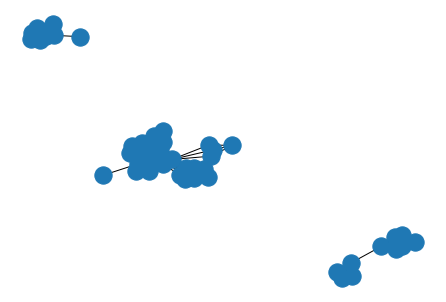

<Figure size 432x288 with 0 Axes>

In [17]:
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [18]:
len(list(nx.connected_components(G))[0])

40

In [19]:
{'Connected Components': 3, 'Nodes In Largest Connected Component': len(list(nx.connected_components(G))[0])}

{'Connected Components': 3, 'Nodes In Largest Connected Component': 40}

# Problem 7

In [20]:
largest = sorted(list(list(nx.connected_components(G))[0]))
lowID = largest[:len(largest)//2]
highID = largest[len(largest)//2:]

In [26]:
nx.normalized_cut_size(G,lowID,highID)/2

0.4224058769513316

# Problem 8

In [40]:
def normalized_cut(G,S,T,weight=None):
    e = nx.edge_boundary(G,S,T,data=weight,default=1)
    nce = sum(weight for u,v,weight in e)
    vs = sum(d for v,d in G.degree(S,weight=weight))
    vt = sum(d for v,d in G.degree(T, weight=weight))
    return (1/2)*nce*((1/vs)+(1/vt))

In [41]:
first_loop = False
second_loop = False
cut_cost = 0
curr_cost = 1
num = 0
low = lowID
high = highID
while cut_cost < curr_cost:
    change = False
    print(1)
    for x in low:
        lowTemp = low
        highTemp = high
        highTemp.append(lowTemp.remove(x))
        #curr_cost = nx.normalized_cut_size(G,lowTemp,highTemp)
        curr_cost = normalized_cut(G,lowTemp,highTemp)
        if curr_cost < cut_cost:
            cut_cost = curr_cost
            num = x
            first_loop = True
            second_loop = False
            change = True
    for x in high:
        lowTemp = low
        highTemp = high
        lowTemp.append(highTemp.remove(x))
        #curr_cost = nx.normalized_cut_size(G,lowTemp,highTemp)
        curr_cost = normalized_cut(G,lowTemp,highTemp)
        if curr_cost < cut_cost:
            cut_cost = curr_cost
            num = x
            first_loop = False
            second_loop = True
            change = True
    if change == True:
        if first_loop == True:
            high.append(low.remove(num))
        else:
            low.append(high.remove(num))

1


ZeroDivisionError: division by zero

In [35]:
len(high)

20

In [13]:
### Find all 3 and 4-cliques in the graph ###
cliques3 = set()
cliques4 = set()
for n1 in nodes:
  for n2 in nodes:
    if not ((n1,n2) in edges): continue
    for n3 in nodes:
      if not ((n1,n3) in edges): continue
      if not ((n2,n3) in edges): continue
      clique = [n1,n2,n3]
      clique.sort()
      cliques3.add(tuple(clique))
      for n4 in nodes:
        if not ((n1,n4) in edges): continue
        if not ((n2,n4) in edges): continue
        if not ((n3,n4) in edges): continue
        clique = [n1,n2,n3,n4]
        clique.sort()
        cliques4.add(tuple(clique))